In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2025-11-05 11:33:07.648332: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 11:33:08.143124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-05 11:33:08.143249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-05 11:33:08.223511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-05 11:33:08.394955: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# ==========================================
# 📁 DATASET CONFIGURATION
# ==========================================
data_dir = "/storage/dataset_balanced"
img_size = (224, 224)
batch_size = 64
seed = 123

# ✅ Split into train+val (90%) and test (10%)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.10,  # Changed from 0.15 to 0.10
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.10,  # Changed from 0.15 to 0.10
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# ✅ Class info
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ==========================================
# 🔀 Split train_val (90%) into train (80%) & val (10%)
# ==========================================
train_val_count = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_count * (80/90))  # (80%/90%) ≈ 0.8889

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

# ✅ Verify splits
print(f"\nDataset splits:")
print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Val batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


Found 49583 files belonging to 5 classes.
Using 44625 files for training.


2025-11-05 11:33:15.429643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-05 11:33:15.749833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-05 11:33:15.750025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 49583 files belonging to 5 classes.
Using 4958 files for validation.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'myopia', 'normal']

Dataset splits:
Train batches: 620
Val batches: 78
Test batches: 78


In [3]:
from tensorflow.keras.models import load_model

model = load_model("/storage/efficientnetb3_finetuned_90_val.keras")


In [5]:
# First, make sure the model is trainable
model.trainable = True

# Get total number of layers
total_layers = len(model.layers)
print(f"Total layers in model: {total_layers}")

# Calculate which layer to start unfreezing from (unfreeze last 180 layers)
unfreeze_from = max(0, total_layers - 180)

# Freeze all layers first
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 180 layers
for layer in model.layers[unfreeze_from:]:
    layer.trainable = True

# Optional: Print trainable status summary
trainable_count = sum([1 for layer in model.layers if layer.trainable])
print(f"Unfreezing from layer index: {unfreeze_from}")
print(f"Number of trainable layers: {trainable_count}")

# After unfreezing, you need to recompile the model
# Example compilation (adjust optimizer, loss, and metrics as needed):


Total layers in model: 5
Unfreezing from layer index: 0
Number of trainable layers: 5


In [6]:
from tensorflow import keras

# Load the model
model = keras.models.load_model("/storage/efficientnetb3_finetuned_90_val.keras")

# Access the base model (usually the first layer if you used functional API)
# Try to find which layer contains EfficientNetB3
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} - Type: {type(layer).__name__}")

# Assuming the base model is at index 0 or has 'efficientnet' in the name
base_model = None
for layer in model.layers:
    if 'efficientnet' in layer.name.lower() or hasattr(layer, 'layers'):
        base_model = layer
        break

if base_model is not None:
    # Now unfreeze the last 180 layers of the BASE model
    base_model.trainable = True
    total_base_layers = len(base_model.layers)
    print(f"Total layers in base model: {total_base_layers}")
    
    unfreeze_from = max(0, total_base_layers - 180)
    
    # Freeze all base layers first
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze the last 180 layers
    for layer in base_model.layers[unfreeze_from:]:
        layer.trainable = True
    
    # Count trainable layers
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"Unfreezing from layer index: {unfreeze_from}")
    print(f"Number of trainable layers in base: {trainable_count}")
    
    # MUST recompile after unfreezing
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    print("Could not find EfficientNetB3 base model inside the loaded model")


Layer 0: efficientnetb3 - Type: Functional
Layer 1: global_average_pooling2d - Type: GlobalAveragePooling2D
Layer 2: dense - Type: Dense
Layer 3: dropout - Type: Dropout
Layer 4: dense_1 - Type: Dense
Total layers in base model: 385
Unfreezing from layer index: 205
Number of trainable layers in base: 180


In [5]:
from tensorflow.keras import metrics

metrics = [
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    
]


In [12]:
# Recompile with a low learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Very small LR
    loss='categorical_crossentropy',
    metrics=metrics
)

print("Model recompiled and ready for fine-tuning!")


Model recompiled and ready for fine-tuning!


Epoch 1/25


2025-11-04 12:28:55.256257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


620/620 [==============================] - 285s 422ms/step - loss: 0.4568 - accuracy: 0.8175 - precision: 0.8331 - recall: 0.7991 - auc: 0.9722 - val_loss: 0.3624 - val_accuracy: 0.8461 - val_precision: 0.8515 - val_recall: 0.8352 - val_auc: 0.9815 - lr: 1.0000e-05
Epoch 2/25
620/620 [==============================] - 287s 459ms/step - loss: 0.3502 - accuracy: 0.8547 - precision: 0.8666 - recall: 0.8382 - auc: 0.9826 - val_loss: 0.3245 - val_accuracy: 0.8572 - val_precision: 0.8630 - val_recall: 0.8481 - val_auc: 0.9847 - lr: 1.0000e-05
Epoch 3/25
620/620 [==============================] - 252s 404ms/step - loss: 0.3050 - accuracy: 0.8712 - precision: 0.8805 - recall: 0.8599 - auc: 0.9866 - val_loss: 0.3033 - val_accuracy: 0.8708 - val_precision: 0.8754 - val_recall: 0.8653 - val_auc: 0.9864 - lr: 1.0000e-05
Epoch 4/25
620/620 [==============================] - 255s 409ms/step - loss: 0.2736 - accuracy: 0.8831 - precision: 0.8912 - recall: 0.8750 - auc: 0.9890 - val_loss: 0.2913 - val_

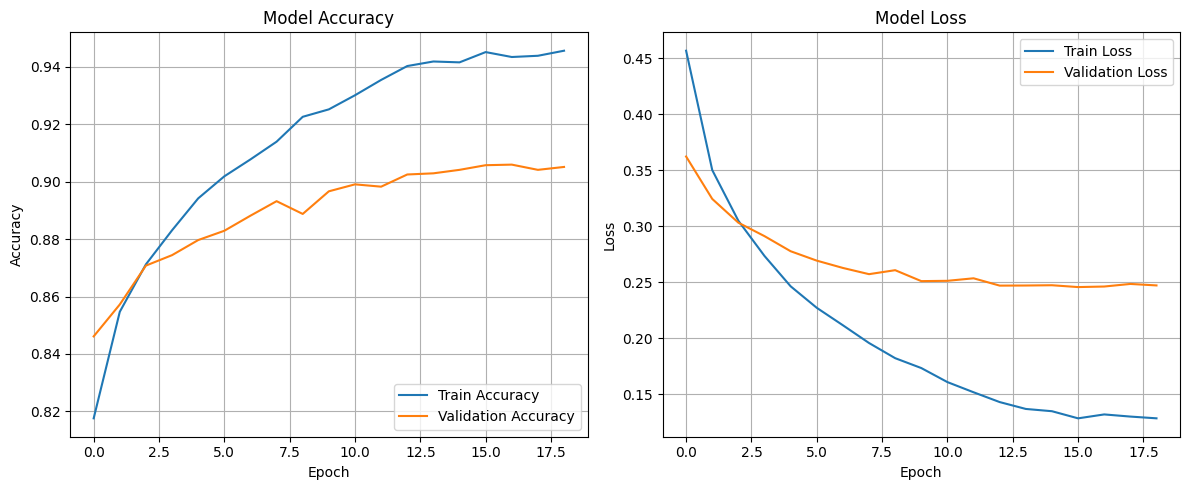

78/78 [==============================] - 109s 157ms/step


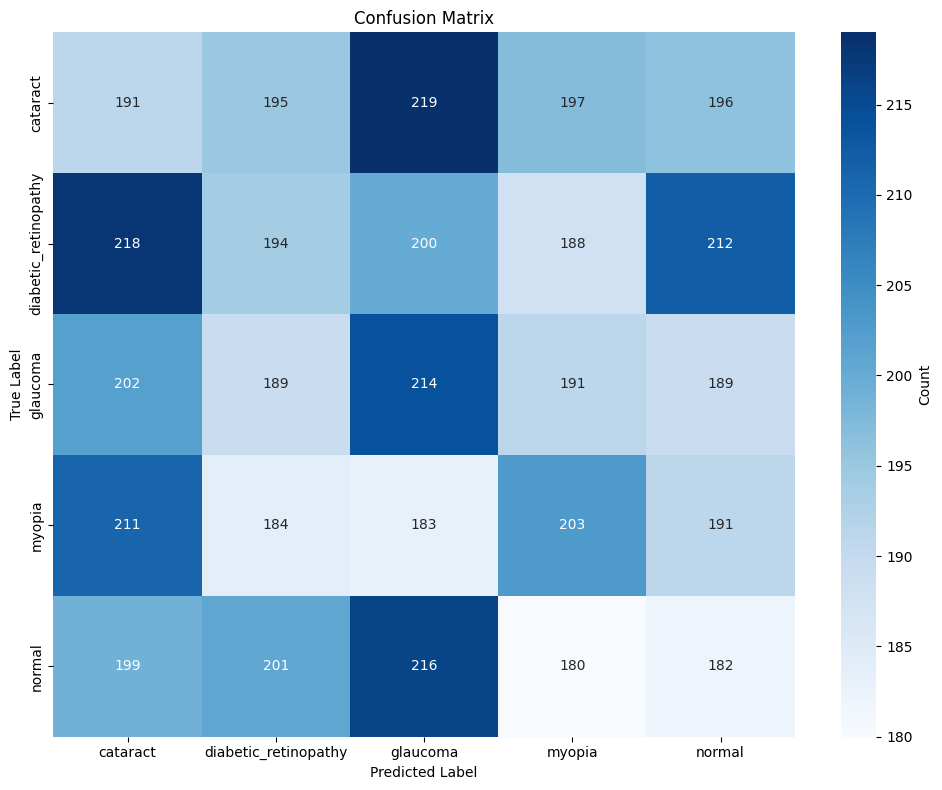


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.1871    0.1914    0.1892       998
diabetic_retinopathy     0.2015    0.1917    0.1965      1012
            glaucoma     0.2074    0.2173    0.2122       985
              myopia     0.2117    0.2088    0.2103       972
              normal     0.1876    0.1861    0.1869       978

            accuracy                         0.1990      4945
           macro avg     0.1990    0.1991    0.1990      4945
        weighted avg     0.1990    0.1990    0.1989      4945


PER-CLASS ACCURACY
cataract: 19.14% (191/998)
diabetic_retinopathy: 19.17% (194/1012)
glaucoma: 21.73% (214/985)
myopia: 20.88% (203/972)
normal: 18.61% (182/978)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================================
# 🎯 TRAIN THE MODEL
# ==========================================
epochs = 25  # Adjust as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

# ==========================================
# 📊 PLOT ACCURACY AND LOSS GRAPHS
# ==========================================
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# 🎯 GENERATE PREDICTIONS FOR CONFUSION MATRIX
# ==========================================
# Get predictions on validation set
y_pred_proba = model.predict(val_ds)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels from validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


Total samples: 4945
Shape check - y_true: (4945,), y_pred: (4945,)


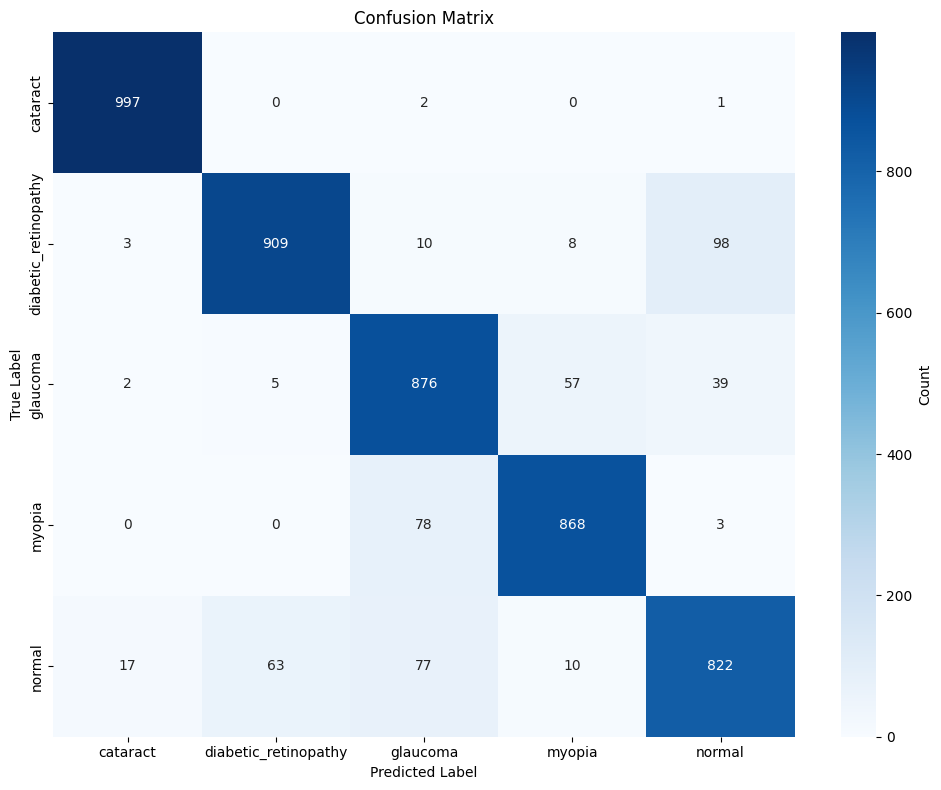


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.9784    0.9970    0.9876      1000
diabetic_retinopathy     0.9304    0.8842    0.9067      1028
            glaucoma     0.8399    0.8948    0.8665       979
              myopia     0.9205    0.9146    0.9175       949
              normal     0.8536    0.8311    0.8422       989

            accuracy                         0.9043      4945
           macro avg     0.9045    0.9044    0.9041      4945
        weighted avg     0.9049    0.9043    0.9043      4945


PER-CLASS ACCURACY
cataract: 99.70% (997/1000)
diabetic_retinopathy: 88.42% (909/1028)
glaucoma: 89.48% (876/979)
myopia: 91.46% (868/949)
normal: 83.11% (822/989)


In [14]:
# ==========================================
# 🎯 GENERATE PREDICTIONS FOR CONFUSION MATRIX
# ==========================================
# FIXED VERSION: Collect predictions and true labels together
y_true = []
y_pred_proba = []

# Iterate once through val_ds to get both labels and predictions
for images, labels in val_ds:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Get predictions for this batch
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Total samples: {len(y_true)}")
print(f"Shape check - y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


In [15]:
# ==========================================
# 💾 SAVE THE CURRENT MODEL (180 layers)
# ==========================================

# Save the entire model
model.save("/storage/efficientnetb3_finetuned_180layers_90acc.keras")
print("✅ Model saved as: efficientnetb3_finetuned_180layers_90acc.keras")

# Also save just the weights (lighter file)
model.save_weights("/storage/efficientnetb3_weights_180layers_90acc.weights.h5")
print("✅ Weights saved as: efficientnetb3_weights_180layers_90acc.weights.h5")

# Save training history
import pickle
with open('/storage/training_history_180layers.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✅ Training history saved")

# Save the classification report
with open('/storage/classification_report_180layers.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("CLASSIFICATION REPORT - 180 Layers Unfrozen\n")
    f.write("="*60 + "\n")
    f.write(f"Overall Accuracy: 90.43%\n\n")
    f.write(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("✅ Classification report saved")


✅ Model saved as: efficientnetb3_finetuned_180layers_90acc.keras
✅ Weights saved as: efficientnetb3_weights_180layers_90acc.weights.h5
✅ Training history saved
✅ Classification report saved


In [16]:
# ==========================================
# 🔓 UNFREEZE 250 LAYERS
# ==========================================

# Get the base model
base_model = model.layers[0]

# Calculate starting point for 250 layers
total_base_layers = len(base_model.layers)
unfreeze_from = max(0, total_base_layers - 250)

print(f"Total base layers: {total_base_layers}")
print(f"Unfreezing from layer {unfreeze_from} to {total_base_layers}")
print(f"Number of layers to unfreeze: {total_base_layers - unfreeze_from}")

# Freeze all first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 250, but keep BatchNormalization frozen
for layer in base_model.layers[unfreeze_from:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False  # Keep BN frozen!

# Count trainable layers
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers: {trainable_count}")

# Recompile with LOWER learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Much lower!
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("✅ Model recompiled with 250 layers unfrozen")
print("⚠️ Using learning rate: 1e-6 (very low to prevent catastrophic forgetting)")


Total base layers: 385
Unfreezing from layer 135 to 385
Number of layers to unfreeze: 250
Trainable layers: 199
✅ Model recompiled with 250 layers unfrozen
⚠️ Using learning rate: 1e-6 (very low to prevent catastrophic forgetting)


Epoch 1/25


2025-11-04 14:23:30.222549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


620/620 [==============================] - 290s 430ms/step - loss: 0.1115 - accuracy: 0.9525 - precision: 0.9538 - recall: 0.9512 - auc: 0.9981 - val_loss: 0.2549 - val_accuracy: 0.9037 - val_precision: 0.9045 - val_recall: 0.9025 - val_auc: 0.9895 - lr: 1.0000e-06
Epoch 2/25
620/620 [==============================] - 261s 418ms/step - loss: 0.1077 - accuracy: 0.9542 - precision: 0.9551 - recall: 0.9532 - auc: 0.9982 - val_loss: 0.2582 - val_accuracy: 0.9021 - val_precision: 0.9033 - val_recall: 0.9015 - val_auc: 0.9893 - lr: 1.0000e-06
Epoch 3/25
620/620 [==============================] - 293s 471ms/step - loss: 0.1083 - accuracy: 0.9530 - precision: 0.9541 - recall: 0.9520 - auc: 0.9982 - val_loss: 0.2571 - val_accuracy: 0.9054 - val_precision: 0.9060 - val_recall: 0.9041 - val_auc: 0.9890 - lr: 1.0000e-06
Epoch 4/25
620/620 [==============================] - 275s 441ms/step - loss: 0.1064 - accuracy: 0.9546 - precision: 0.9559 - recall: 0.9535 - auc: 0.9983 - val_loss: 0.2588 - val_

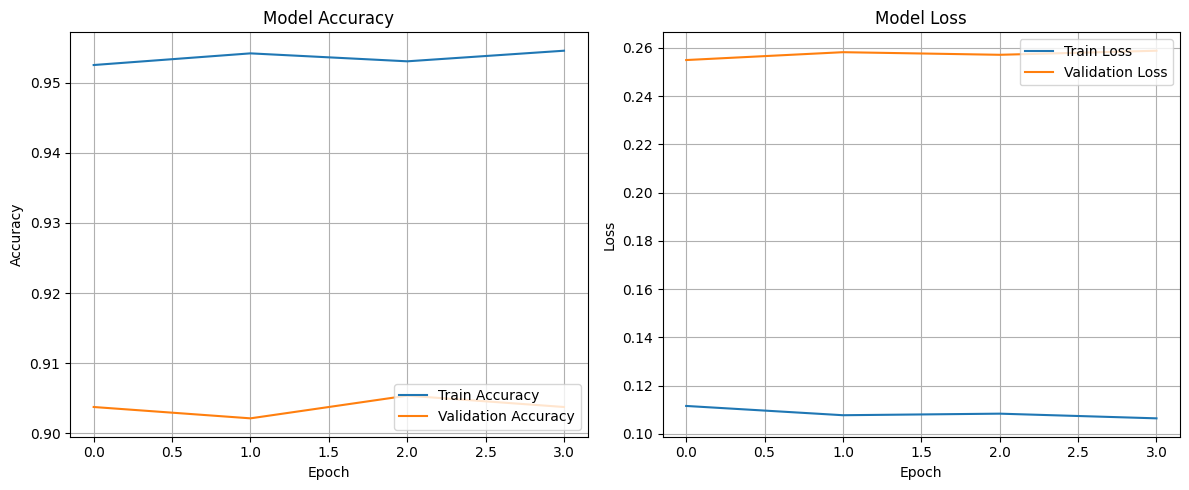

Total samples: 4945
Shape check - y_true: (4945,), y_pred: (4945,)


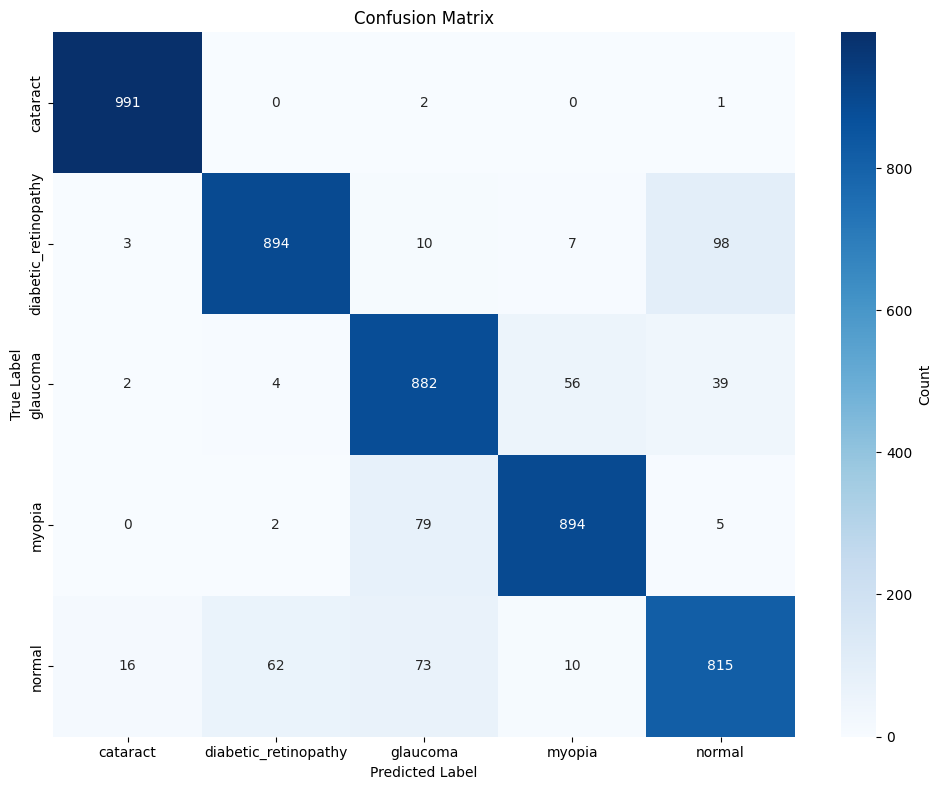


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.9792    0.9970    0.9880       994
diabetic_retinopathy     0.9293    0.8834    0.9058      1012
            glaucoma     0.8432    0.8973    0.8694       983
              myopia     0.9245    0.9122    0.9183       980
              normal     0.8507    0.8350    0.8428       976

            accuracy                         0.9052      4945
           macro avg     0.9054    0.9050    0.9049      4945
        weighted avg     0.9058    0.9052    0.9051      4945


PER-CLASS ACCURACY
cataract: 99.70% (991/994)
diabetic_retinopathy: 88.34% (894/1012)
glaucoma: 89.73% (882/983)
myopia: 91.22% (894/980)
normal: 83.50% (815/976)


In [17]:
epochs = 25  # Adjust as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

# ==========================================
# 📊 PLOT ACCURACY AND LOSS GRAPHS
# ==========================================
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# ==========================================
# 🎯 GENERATE PREDICTIONS FOR CONFUSION MATRIX
# ==========================================
# FIXED VERSION: Collect predictions and true labels together
y_true = []
y_pred_proba = []

# Iterate once through val_ds to get both labels and predictions
for images, labels in val_ds:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Get predictions for this batch
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Total samples: {len(y_true)}")
print(f"Shape check - y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")


In [4]:
from tensorflow import keras
import tensorflow as tf

# ==========================================
# 📥 LOAD MODEL & ACCESS BASE MODEL
# ==========================================

model = keras.models.load_model("/storage/efficientnetb3_finetuned_180layers_90acc.keras")
print("✅ Model loaded successfully")
print(f"📊 Top-level layers: {len(model.layers)}")

# Find the EfficientNetB3 base model (usually the first or second layer)
base_model = None
for layer in model.layers:
    if 'efficientnet' in layer.name.lower():
        base_model = layer
        break

# If not found by name, try the first layer (common pattern)
if base_model is None:
    base_model = model.layers[0]
    print(f"⚠️ Using layer '{base_model.name}' as base model")

print(f"\n📊 Base model layers: {len(base_model.layers)}")
print(f"📊 Base model name: {base_model.name}")

# ==========================================
# 🔓 UNFREEZE LAST 280 LAYERS OF BASE MODEL
# ==========================================

layers_to_unfreeze = 280
total_base_layers = len(base_model.layers)

if total_base_layers >= layers_to_unfreeze:
    freeze_until = total_base_layers - layers_to_unfreeze
    
    # Freeze early layers, unfreeze the rest
    for i, layer in enumerate(base_model.layers):
        if i < freeze_until:
            layer.trainable = False
        else:
            layer.trainable = True
    
    print(f"\n✅ Unfroze the last {layers_to_unfreeze} layers of base model")
    print(f"📌 Frozen base layers: {freeze_until}")
    print(f"📌 Trainable base layers: {layers_to_unfreeze}")
else:
    # Unfreeze all base model layers
    for layer in base_model.layers:
        layer.trainable = True
    print(f"\n✅ Unfroze all {total_base_layers} base layers")

# Make sure the base model itself is trainable
base_model.trainable = True

# ==========================================
# 📊 VERIFY CHANGES
# ==========================================

# Count trainable layers in base model
base_trainable = sum([1 for layer in base_model.layers if layer.trainable])
base_frozen = len(base_model.layers) - base_trainable

print(f"\n📈 Base Model Status:")
print(f"   Total base layers: {len(base_model.layers)}")
print(f"   Trainable base layers: {base_trainable}")
print(f"   Frozen base layers: {base_frozen}")

# Count trainable parameters across entire model
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"\n📈 Full Model Status:")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Non-trainable parameters: {non_trainable_params:,}")
print(f"   Total parameters: {trainable_params + non_trainable_params:,}")

# ==========================================
# 🔄 RECOMPILE WITH LOWER LEARNING RATE
# ==========================================

# Use a very low learning rate when unfreezing many layers
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),  # Very low LR
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n✅ Model recompiled with learning_rate=1e-6")
print("💡 Ready for fine-tuning with 280 unfrozen layers")
print("⚠️ Recommended: Train for 10-20 epochs with early stopping")


✅ Model loaded successfully
📊 Top-level layers: 5

📊 Base model layers: 385
📊 Base model name: efficientnetb3

✅ Unfroze the last 280 layers of base model
📌 Frozen base layers: 105
📌 Trainable base layers: 280

📈 Base Model Status:
   Total base layers: 385
   Trainable base layers: 385
   Frozen base layers: 0

📈 Full Model Status:
   Trainable parameters: 11,485,741
   Non-trainable parameters: 87,303
   Total parameters: 11,573,044

✅ Model recompiled with learning_rate=1e-6
💡 Ready for fine-tuning with 280 unfrozen layers
⚠️ Recommended: Train for 10-20 epochs with early stopping


In [7]:
# Find the EfficientNetB3 base model
base_model = None
for layer in model.layers:
    if 'efficientnet' in layer.name.lower():
        base_model = layer
        break

print(f"📊 Base model layers: {len(base_model.layers)}")

# ==========================================
# 🔓 UNFREEZE LAST 280 LAYERS (CORRECT METHOD)
# ==========================================

layers_to_unfreeze = 280
total_base_layers = len(base_model.layers)
freeze_until = total_base_layers - layers_to_unfreeze

# First, set base_model as trainable
base_model.trainable = True

# Then freeze specific early layers
for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

print(f"\n✅ Configuration set: Last {layers_to_unfreeze} layers unfrozen")

# ==========================================
# 📊 VERIFY (AFTER RECOMPILING)
# ==========================================

# IMPORTANT: Must recompile before checking trainable status
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics= metrics
)

print("✅ Model recompiled\n")

# NOW check the actual trainable status
base_trainable = sum([1 for layer in base_model.layers if layer.trainable])
base_frozen = len(base_model.layers) - base_trainable

print(f"📈 Base Model Status (After Recompile):")
print(f"   Total base layers: {len(base_model.layers)}")
print(f"   Trainable base layers: {base_trainable}")
print(f"   Frozen base layers: {base_frozen}")

trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"\n📈 Full Model Parameters:")
print(f"   Trainable: {trainable_params:,}")
print(f"   Non-trainable: {non_trainable_params:,}")
print(f"   Total: {trainable_params + non_trainable_params:,}")

# Show which layer range is frozen/unfrozen
print(f"\n📍 Layer Configuration:")
print(f"   Layers 0-{freeze_until-1}: FROZEN ❄️")
print(f"   Layers {freeze_until}-{total_base_layers-1}: TRAINABLE 🔥")

# ==========================================
# 💾 SAVE UPDATED MODEL
# ==========================================



📊 Base model layers: 385

✅ Configuration set: Last 280 layers unfrozen
✅ Model recompiled

📈 Base Model Status (After Recompile):
   Total base layers: 385
   Trainable base layers: 280
   Frozen base layers: 105

📈 Full Model Parameters:
   Trainable: 11,350,955
   Non-trainable: 222,089
   Total: 11,573,044

📍 Layer Configuration:
   Layers 0-104: FROZEN ❄️
   Layers 105-384: TRAINABLE 🔥


Epoch 1/25


2025-11-05 11:42:01.751765: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-05 11:42:06.958290: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-05 11:42:08.903911: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5ffd81fe40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-05 11:42:08.903951: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-11-05 11:42:08.945962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762342929.116605     100 device_compiler.h:186] Compiled clu

620/620 [==============================] - 334s 472ms/step - loss: 0.3688 - accuracy: 0.8586 - precision: 0.8647 - recall: 0.8524 - auc: 0.9816 - val_loss: 0.3792 - val_accuracy: 0.8548 - val_precision: 0.8592 - val_recall: 0.8499 - val_auc: 0.9809 - lr: 1.0000e-06
Epoch 2/25
620/620 [==============================] - 282s 452ms/step - loss: 0.3290 - accuracy: 0.8711 - precision: 0.8771 - recall: 0.8652 - auc: 0.9847 - val_loss: 0.3510 - val_accuracy: 0.8619 - val_precision: 0.8662 - val_recall: 0.8578 - val_auc: 0.9831 - lr: 1.0000e-06
Epoch 3/25
620/620 [==============================] - 286s 459ms/step - loss: 0.3053 - accuracy: 0.8776 - precision: 0.8837 - recall: 0.8721 - auc: 0.9865 - val_loss: 0.3340 - val_accuracy: 0.8677 - val_precision: 0.8737 - val_recall: 0.8647 - val_auc: 0.9845 - lr: 1.0000e-06
Epoch 4/25
620/620 [==============================] - 284s 456ms/step - loss: 0.2823 - accuracy: 0.8836 - precision: 0.8893 - recall: 0.8780 - auc: 0.9883 - val_loss: 0.3291 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



620/620 [==============================] - 289s 463ms/step - loss: 0.2087 - accuracy: 0.9113 - precision: 0.9152 - recall: 0.9066 - auc: 0.9934 - val_loss: 0.2772 - val_accuracy: 0.8863 - val_precision: 0.8881 - val_recall: 0.8839 - val_auc: 0.9886 - lr: 1.0000e-06
Epoch 14/25
620/620 [==============================] - 279s 448ms/step - loss: 0.2042 - accuracy: 0.9134 - precision: 0.9174 - recall: 0.9097 - auc: 0.9937 - val_loss: 0.2755 - val_accuracy: 0.8878 - val_precision: 0.8897 - val_recall: 0.8857 - val_auc: 0.9887 - lr: 1.0000e-06
Epoch 15/25
620/620 [==============================] - 281s 451ms/step - loss: 0.1966 - accuracy: 0.9163 - precision: 0.9205 - recall: 0.9122 - auc: 0.9942 - val_loss: 0.2719 - val_accuracy: 0.8890 - val_precision: 0.8912 - val_recall: 0.8876 - val_auc: 0.9888 - lr: 1.0000e-06
Epoch 16/25
620/620 [==============================] - 284s 457ms/step - loss: 0.1939 - accuracy: 0.9190 - precision: 0.9226 - recall: 0.9149 - auc: 0.9943 - val_loss: 0.2671 - v

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



620/620 [==============================] - 299s 480ms/step - loss: 0.1760 - accuracy: 0.9265 - precision: 0.9297 - recall: 0.9235 - auc: 0.9952 - val_loss: 0.2557 - val_accuracy: 0.8983 - val_precision: 0.9004 - val_recall: 0.8963 - val_auc: 0.9896 - lr: 1.0000e-06
Epoch 23/25
620/620 [==============================] - 293s 470ms/step - loss: 0.1717 - accuracy: 0.9274 - precision: 0.9301 - recall: 0.9246 - auc: 0.9955 - val_loss: 0.2607 - val_accuracy: 0.8965 - val_precision: 0.8985 - val_recall: 0.8950 - val_auc: 0.9893 - lr: 1.0000e-06
Epoch 24/25
620/620 [==============================] - 297s 477ms/step - loss: 0.1696 - accuracy: 0.9296 - precision: 0.9322 - recall: 0.9265 - auc: 0.9956 - val_loss: 0.2592 - val_accuracy: 0.8977 - val_precision: 0.8991 - val_recall: 0.8961 - val_auc: 0.9894 - lr: 1.0000e-06
Epoch 25/25
620/620 [==============================] - 290s 466ms/step - loss: 0.1703 - accuracy: 0.9278 - precision: 0.9309 - recall: 0.9249 - auc: 0.9956 - val_loss: 0.2611 - v

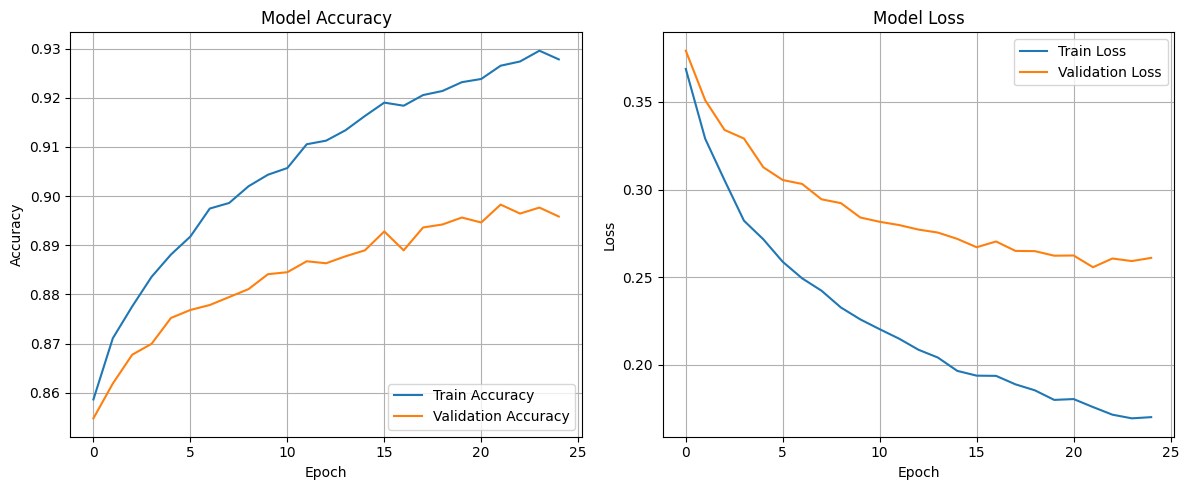

NameError: name 'np' is not defined

In [ ]:
epochs = 25  # Adjust as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
    ]
)

# ==========================================
# 📊 PLOT ACCURACY AND LOSS GRAPHS
# ==========================================
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()



In [9]:
import numpy as np

Total samples: 4945
Shape check - y_true: (4945,), y_pred: (4945,)


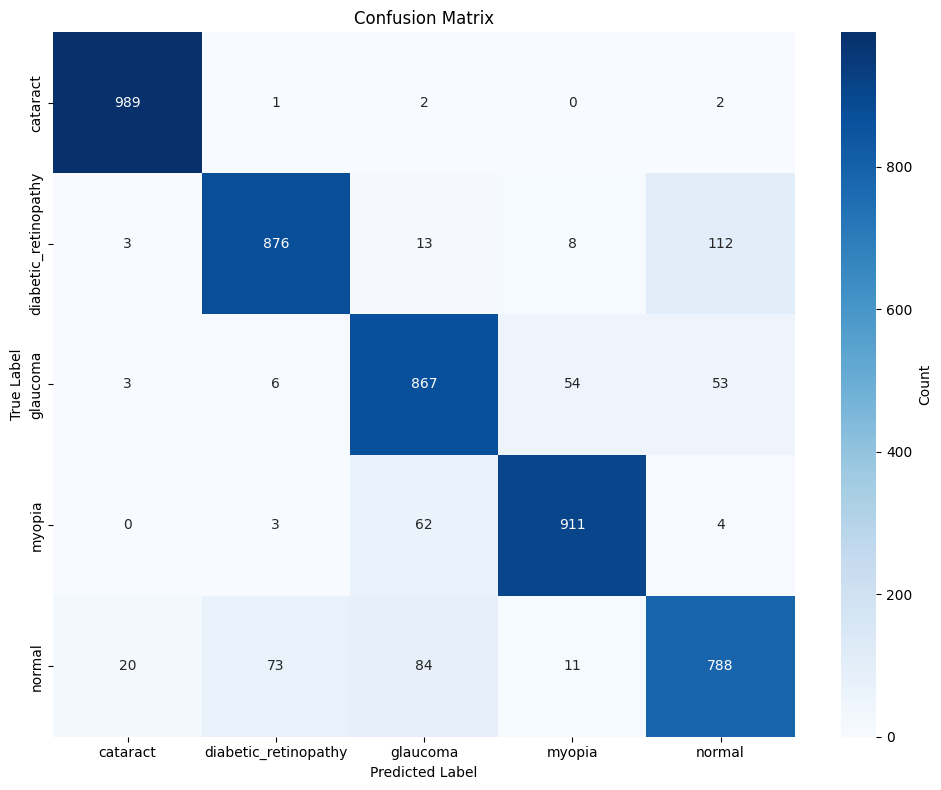


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

            cataract     0.9744    0.9950    0.9846       994
diabetic_retinopathy     0.9135    0.8656    0.8889      1012
            glaucoma     0.8434    0.8820    0.8623       983
              myopia     0.9258    0.9296    0.9277       980
              normal     0.8217    0.8074    0.8145       976

            accuracy                         0.8961      4945
           macro avg     0.8957    0.8959    0.8956      4945
        weighted avg     0.8961    0.8961    0.8958      4945


PER-CLASS ACCURACY
cataract: 99.50% (989/994)
diabetic_retinopathy: 86.56% (876/1012)
glaucoma: 88.20% (867/983)
myopia: 92.96% (911/980)
normal: 80.74% (788/976)


In [10]:

# ==========================================
# 🎯 GENERATE PREDICTIONS FOR CONFUSION MATRIX
# ==========================================
# FIXED VERSION: Collect predictions and true labels together
y_true = []
y_pred_proba = []

# Iterate once through val_ds to get both labels and predictions
for images, labels in val_ds:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Get predictions for this batch
    batch_preds = model.predict(images, verbose=0)
    y_pred_proba.extend(batch_preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Total samples: {len(y_true)}")
print(f"Shape check - y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# ==========================================
# 📈 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ==========================================
# 📋 CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# ==========================================
# 📊 PER-CLASS ACCURACY
# ==========================================
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy:.2f}% ({class_correct}/{class_total})")
